In [626]:
import pandas as pd                                               # Import pandas library for working with tabular data (DataFrame)
import numpy as np                                                # Import numpy library for working with arrays and numeric operations
import seaborn as sns                                             # Import seaborn library for creating beautiful and informative data visualisations
from matplotlib import pyplot as plt                              # Import pyplot function from matplotlib library for creating graphs and visualisations.

from sklearn.preprocessing import OneHotEncoder, StandardScaler   # Import of classes for categorical feature encoding and data standardisation
from sklearn.model_selection import train_test_split              # Import of functions for splitting data into training and test samples.

from sklearn.linear_model import LogisticRegression               # Import logistic regression model
from sklearn.neighbors import KNeighborsClassifier                # Import K-nearest neighbours classifier
from sklearn.tree import DecisionTreeClassifier                   # Import decision tree based classifier
from sklearn.svm import SVC                                       # Import support vector method (SVM) classifier


from sklearn import metrics                                       # Import the entire metrics module to work with model estimation metrics
from sklearn.metrics import (                                     # Import specific estimation functions from the metrics submodule
 accuracy_score,                                                  # Import a function to estimate the accuracy of a model, i.e. the fraction of correctly predicted examples balanced_accuracy_score, # Import a function to estimate balanced accuracy that takes into account class heterogeneity precision_score, # Import a function to compute precision_score. proportion of correctly predicted examples
 balanced_accuracy_score,                                         # Import function for estimating balanced accuracy that takes into account class heterogeneity
 precision_score,                                                 # Import function for calculating precision
 recall_score,                                                    # Import function for calculating completeness
 confusion_matrix,                                                # Import function for creating a confusion matrix: TN, TP, FN, FP
 multilabel_confusion_matrix,                                     # Import function to create error matrix for multivariate classification cases
 f1_score,                                                        # Import function to compute F1-measure
 roc_auc_score,                                                   # Import function to compute AUC-ROC (area under the acceptability and error curve)
 roc_curve,                                                       # Import function for calculating coordinates for plotting ROC curve
 average_precision_score,                                         # Import function for calculating average precision
 precision_recall_curve                                           # Import function for calculating and visualising precision-recall curve
)



Let's download the data

In [627]:
data = pd.read_excel('ready_data.xlsx')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 72 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   Age                                                                                                 770 non-null    float64
 1   BMI                                                                                                 770 non-null    float64
 2   Sex                                                                                                 770 non-null    float64
 3   Length_of_Stay                                                                                      770 non-null    int64  
 4   Severity                                                                                            770 non-null    

I'll remove the columns on diagnoses and surgeries. We have decided to concentrate on predicting the presence or absence of appendicitis, so we are not interested in diagnoses and surgeries at this time

In [628]:
post_fact_info = [
    'Diagnosis_Presumptive_Adhäsionen des Colon ascendens',
    'Diagnosis_Presumptive_Appendizitis, Lymphadenitis mesenterialis',                                      
    'Diagnosis_Presumptive_Appendizitis/ Lymphadenitis mesenterialis',                                       
    'Diagnosis_Presumptive_Bridenileus',                                                                     
    'Diagnosis_Presumptive_Gastroenteritis',                                                                
    'Diagnosis_Presumptive_Ovarialtorsion',                                                                  
    'Diagnosis_Presumptive_Sepsis mit Begleitappendizitis',                                                
    'Diagnosis_Presumptive_abdominelle Adhäsionen, chron. Unterbauchbeschwerden mit Subileussymptomatik',   
    'Diagnosis_Presumptive_appendicitis',                                                                    
    'Diagnosis_Presumptive_chronische Appendizitis',                                                        
    'Diagnosis_Presumptive_chronische Bauchschmerzen',                                                     
    'Diagnosis_Presumptive_diabetische Ketoazidose, Myokarditis',                                          
    'Diagnosis_Presumptive_gedeckt perforierte Appendizitis',                                            
    'Diagnosis_Presumptive_no appendicitis',                                                               
    'Diagnosis_Presumptive_prolongierte Gastroenteritis',                                                 
    'Management_conservative',                                                                             
    'Management_primary surgical',                                                                           
    'Management_secondary surgical',                                                                      
    'Management_simultaneous appendectomy',
    'Severity'
    ]

data.drop(columns=post_fact_info, inplace=True)

### I. Partitioning data for training

In [629]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop("Diagnosis", axis=1),
    data["Diagnosis"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=data["Diagnosis"]
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((616, 51), (154, 51), (616,), (154,))

In [630]:
# Normalisation for better results
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape

((616, 51), (154, 51), (616, 51), (154, 51))

### II.Training and quality assessment of models

1. Function for train and test of model

In [631]:
def model_train_test(X_train, y_train, X_test, y_test, model, **kwargs):
    """Training and testing of the model on the training and test samples respectively.
    Function arguments:
    X_train: objects of training sample
    y_train: values of target variable of training sample
    X_test: objects of test sample
    y_test: values of target variable of test sample
    model: model that is trained and tested
    Function returns predictions - classes and probabilities of belonging to each class, all metrics
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    """
    The predict method is used to get the final class predictions for a given dataset.
    It returns the classes (labels) for objects based on the decision of the model. For binary classification, possible values can be 0 or 1
    """
    if isinstance(model, LogisticRegression):
        importance = model.coef_[0]
    elif isinstance(model, DecisionTreeClassifier):
        importance = model.feature_importances_
    else:
         importance = None
    """
    The isinstance() function in Python checks whether an object is an instance of the specified class or tuple of classes.
    It returns True if the object matches the specified type, and False otherwise.
    In our case, it checks if the model object is an instance of the LogisticRegression or DecisionTreeClassifier class
    Logistic Regression:
    classifier.coef_ is a model attribute that contains coefficients (weights) before each feature.
    The index [0] in classifier.coef_[0] is used to access the coefficients of the first class.
    Hence, the code importance = classifier.coef_[0] assigns to the variable importance an array of coefficients,
    which the model uses to decide whether a new observation belongs to the first class.
    """
    print(str(model), end="\n\n")

    all_metrics = get_all_metrics(
        y_test,
        pred,
        proba,
        print_metrics=True,
        **kwargs,
    )
    return pred, proba, importance, all_metrics

2. Let's put the calculation of several metrics into a separate function:

In [632]:
def get_all_metrics(
    true_labels,
    predictions,
    probabilities,
    print_metrics=False,
    **kwargs,
):
    """Count and output all metrics
    Function arguments:
    true_labels: true class labels
    predictions: predictions (class labels)
    probabilities: predictions (probabilities of each object belonging to each class)
    print_metrics: if True, prints the resulting metrics.
    **kwargs: special syntax for assembling all additional named arguments into a single dictionary
    Returns:
    dictionary whose keys are precision metrics names, values are precision metrics values
    """

    kwargs_precision_recall_f1_pr_auc = dict()
    kwargs_roc_auc = dict()

    """Two empty dictionaries (`dict` - associative array or dictionary) are created
    1. kwargs_precision_recall_f1_pr_auc = dict():
    Creates an empty dictionary that will be used to pass additional
    arguments (keyword arguments - `kwargs`) to functions related to calculating or visualising metrics such as
    Precision, Recall, F1 Score, PR AUC
    2. kwargs_roc_auc = dict():
    Creates an empty dictionary to which additional parameters will be added for analyses related
    to the ROC curve and the area under it
    """
    probabilities = probabilities[:, 1]
    true_predicted_labels_precision_recall_f1 = {
        "y_true": true_labels,
        "y_pred": predictions,
    }
    true_predicted_labels_pr_auc = {
        "y_true": true_labels,
        "y_score": probabilities,
    }

    """
    probabilities = probabilities[:, 1]: retrieves probabilities for the positive class (second column) from the probabilities predictions array
    true_predicted_labels_precision_recall_f1: creates a dictionary containing:
    "y_true": true class labels (true_labels); "y_pred": predicted class labels (predictions).

    true_predicted_labels_pr_auc: creates a dictionary containing:
    "y_true": true class labels (true_labels); "y_score": probabilities predicted by models (probabilities).
    """

    accuracy = accuracy_score(true_labels, predictions).round(4)
    balanced_accuracy=balanced_accuracy_score(true_labels, predictions).round(4)
    precision = precision_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc).round(4)
    recall = recall_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc).round(4)
    f1 = f1_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc).round(4)

    roc_auc = roc_auc_score(true_labels, probabilities, **kwargs_roc_auc).round(4)
    pr_auc = average_precision_score(**true_predicted_labels_pr_auc, **kwargs_precision_recall_f1_pr_auc).round(4)

    specificity, conf_matrix = calculate_specificity(true_labels, predictions)


    tn, fp, fn, tp = conf_matrix

    if print_metrics:
        print(
            "Accuracy = {}\nBalanced_accuracy={}\nPrecision = {}\nRecall = {}\nF1_score = {}\nROC AUC = {}\nPR AUC = {}\nSpecificity = {}".format(
                accuracy, balanced_accuracy, precision, recall, f1, roc_auc, pr_auc, specificity
            )
        )


    return {
        "Accuracy": accuracy,
        "Balanced accuracy": balanced_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Specificity": specificity
    }

In [633]:
def get_all_metrics(
    true_labels,
    predictions,
    probabilities,
    print_metrics=False,
    **kwargs,
):
    """Подсчёт и вывод всех метрик
  Аргументы функции:
    true_labels: истинные метки классов
    predictions: предсказания (метки классов)
    probabilities: предсказания (вероятности принадлежности каждого объекта к каждому классу)
    print_metrics: если True, то печатает получившиеся метрики
    **kwargs: специальный синтаксис для сборки всех дополнительных именованных аргументов в один словарь
  Возвращает:
    словарь, ключи которого -- названия метрик точности, значения -- значения метрик точности
    """

    kwargs_precision_recall_f1_pr_auc = dict()
    kwargs_roc_auc = dict()

    """Создаются два пустых словаря (`dict` — ассоциативный массив или словарь)
    1. kwargs_precision_recall_f1_pr_auc = dict():
    Создается пустой словарь, который будет использован для передачи дополнительных аргументов
    (keyword arguments — `kwargs`) в функции, связанные с вычислением или визуализацией метрик, таких как
     Precision, Recall, F1 Score, PR AUC
    2. kwargs_roc_auc = dict():
    Создается пустой словарь, в который будут добавлены дополнительные параметры для анализа, связанного
    с ROC  кривой и площадью под ней
    """
    probabilities = probabilities[:, 1]
    true_predicted_labels_precision_recall_f1 = {
        "y_true": true_labels,
        "y_pred": predictions,
    }
    true_predicted_labels_pr_auc = {
        "y_true": true_labels,
        "y_score": probabilities,
    }

    """
    probabilities = probabilities[:, 1]: извлекает вероятности для позитивного класса (второго столбца) из массива предсказаний probabilities
    true_predicted_labels_precision_recall_f1: создаёт словарь, содержащий:
         "y_true": истинные метки классов (true_labels); "y_pred": предсказанные метки классов (predictions).

    true_predicted_labels_pr_auc: создаёт словарь, содержащий:
    "y_true": истинные метки классов (true_labels); "y_score": вероятности, предсказанные моделями (probabilities).
    """

    accuracy = round(accuracy_score(true_labels, predictions), 4)
    balanced_accuracy = round(balanced_accuracy_score(true_labels, predictions), 4)
    precision = round(precision_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc),4)
    recall = round(recall_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc),4)
    f1 = round(f1_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc),4)

    roc_auc = round(roc_auc_score(true_labels, probabilities, **kwargs_roc_auc),4)
    pr_auc = round(average_precision_score(**true_predicted_labels_pr_auc, **kwargs_precision_recall_f1_pr_auc),4)

    specificity, conf_matrix = calculate_specificity(true_labels, predictions)


    tn, fp, fn, tp = conf_matrix

    if print_metrics:
        print(
            "Accuracy = {}\nBalanced_accuracy={}\nPrecision = {}\nRecall = {}\nF1_score = {}\nROC AUC = {}\nPR AUC = {}\nSpecificity = {}".format(
                accuracy, balanced_accuracy, precision, recall, f1, roc_auc, pr_auc, specificity
            )
        )


    return {
        "Accuracy": accuracy,
        "Balanced accuracy": balanced_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Specificity": specificity
    }

In [634]:
def calculate_specificity(true_labels, predictions):
    """Computing specificity for binary and multiclass classification
    Function arguments:
    true_labels: true class labels
    predictions: predicted class labels
    Result:
    specificity and confusion_matrix
    """
    conf_matrix = confusion_matrix(true_labels, predictions)
    tn, fp, fn, tp = conf_matrix.ravel()
    specif = (tn / (tn + fp)).round(4)
    return specif, (tn, fp, fn, tp)

### III. Algorithm Comparison

Let's proceed to the direct comparison of the models. In the binary classification task we will compare:
1) logistic regression, 
2) decision tree, 
3) k-nearest neighbours method 
4) support vector method.

In [635]:
pred_logreg, proba_logreg, importance_logreg, all_metrics_logreg = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    LogisticRegression(solver='liblinear', random_state=42, max_iter=500)
)

# The 'saga' and 'sag' solvers were also tested, but i got an error

LogisticRegression(max_iter=500, random_state=42, solver='liblinear')

Accuracy = 0.8377
Balanced_accuracy=0.826
Precision = 0.8438
Recall = 0.8901
F1_score = 0.8663
ROC AUC = 0.8973
PR AUC = 0.9201
Specificity = 0.7619


- The results are impressive. The ROC AUC is 0,9 and close to 1. Hight Accuracy and Recall rates are very important for ML in medical research.

In [636]:
pred_dt, proba_dt, importance_dt, all_metrics_dt = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    DecisionTreeClassifier(random_state=42)
)

DecisionTreeClassifier(random_state=42)

Accuracy = 0.7273
Balanced_accuracy=0.7131
Precision = 0.7579
Recall = 0.7912
F1_score = 0.7742
ROC AUC = 0.7131
PR AUC = 0.723
Specificity = 0.6349


- The results are worse than LR in every way. The system is neither balanced nor specific

In [637]:
pred_knn, proba_knn, importance_knn, all_metrics_knn = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    KNeighborsClassifier()
)

KNeighborsClassifier()

Accuracy = 0.6688
Balanced_accuracy=0.6416
Precision = 0.6923
Recall = 0.7912
F1_score = 0.7385
ROC AUC = 0.6779
PR AUC = 0.7244
Specificity = 0.4921


- Same situation with the KNC. The specificity is very low quality

In [638]:
pred_svm, proba_svm, importance_svm, all_metrics_svm = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    SVC(probability=True)
)

SVC(probability=True)

Accuracy = 0.6558
Balanced_accuracy=0.6087
Precision = 0.6583
Recall = 0.8681
F1_score = 0.7488
ROC AUC = 0.7401
PR AUC = 0.8103
Specificity = 0.3492


- The situation has repeated itself

Let us consider the error matrices of each classification. They visualise the quality of correct predictions and false diagnoses. For medical tasks it is important for us to have a minimum value of False Negatives, and False Positives

In [639]:
def plot_confusion_matrix(y_true, y_pred, title='Error Matrix'):
    """
    Constructs and visualises the error matrix.
    
    Parameters:
    - y_true: a list or array of true class labels.
    - y_pred: list or array of predicted labels.
    - title: title of the graph (default 'Error Matrix').
    """
    error_matrix = metrics.confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(figsize=(7, 5))
    sns.heatmap(error_matrix, annot=True, fmt='', cmap='Blues')
    axes.set_title(title)
    axes.set_xlabel('Predicted value')
    axes.set_ylabel('True value')
    plt.tight_layout()
    plt.show()

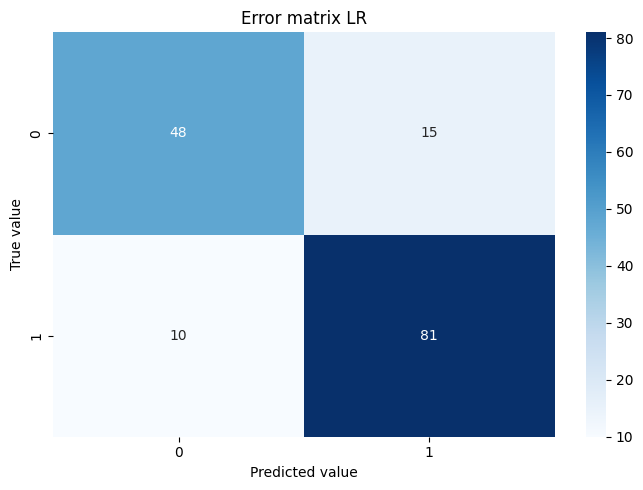

In [640]:
plot_confusion_matrix(y_test, pred_logreg, title='Error matrix LR')

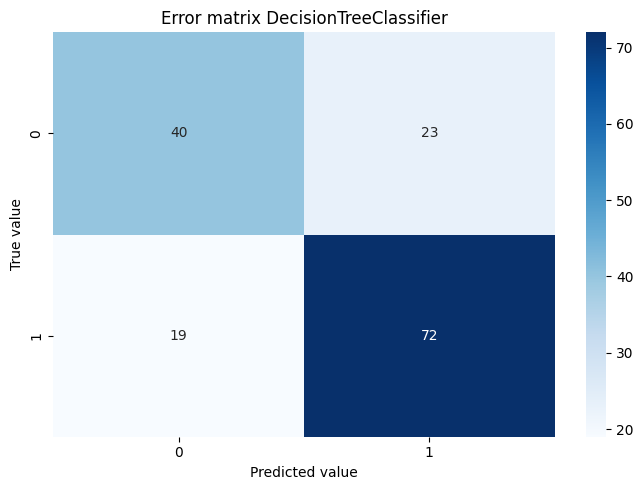

In [641]:
plot_confusion_matrix(y_test, pred_dt, title = 'Error matrix DecisionTreeClassifier')


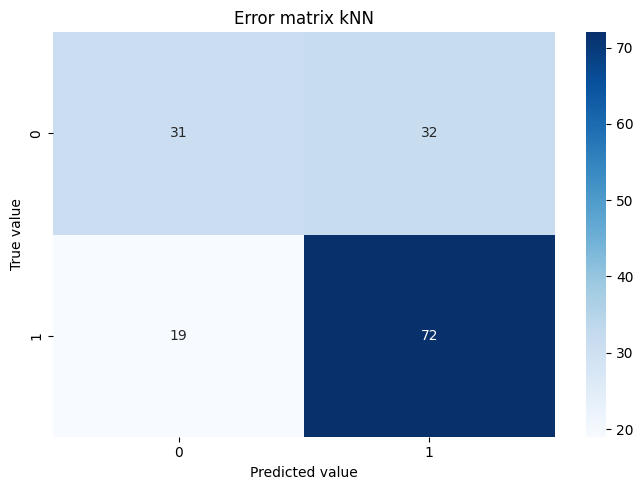

In [642]:
plot_confusion_matrix(y_test, pred_knn, title = 'Error matrix kNN')


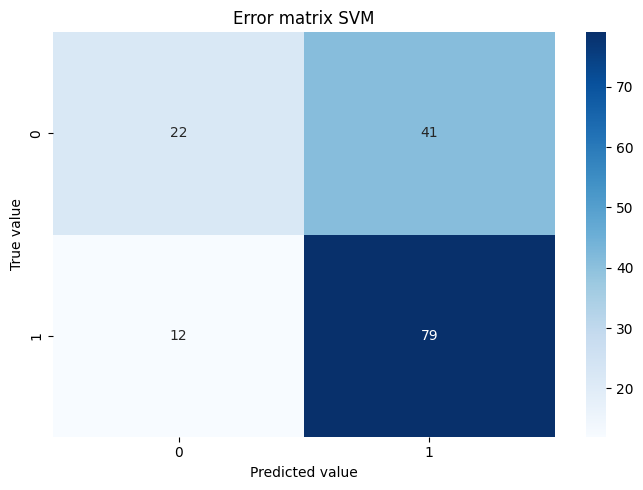

In [643]:
plot_confusion_matrix(y_test, pred_svm, title = 'Error matrix SVM')


Based on the 4 error matrices obtained, we should opt for LR. The sum of the ‘errors’ is 23. Which is the minimum value among the considered ones. I.e. the probability of error is 18%, and dangerous False Negative is only 6%.

Let us compare, at last time, not only the ROC AUC and PR AUC, but also the ROC and PR curves.

To do this, we need the function

In [644]:
def plot_roc_pr_curves(true_labels, algorithms):
    """ROC and PR curves drawing.
    Function arguments:
    true_labels: true class labels
    algorithms: dictionary format {algorithm_name: probabilities_of_ belonging_to_each_class}
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].set_title("ROC-curve", fontsize=20)
    ax[1].set_title("PR-curve", fontsize=20)

    for alg_name, probabilities in algorithms.items():
        fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
        precisions, recalls, _ = precision_recall_curve(true_labels, probabilities[:, 1])

        ax[0].plot(
            fpr,
            tpr,
            label="{} (ROC AUC = {})".format(
                alg_name,
                round(
                    roc_auc_score(true_labels, probabilities[:, 1]),
                    3
                )
            )
        )
        ax[1].plot(
            recalls,
            precisions,
            label="{} (PR AUC = {})".format(
                alg_name,
                round(
                    average_precision_score(true_labels, probabilities[:, 1]),
                    3
                )
            )
        )

    ax[0].legend(fontsize=14)
    ax[0].set_xlabel("False positive rate", fontsize=16)
    ax[0].set_ylabel("True positive rate", fontsize=16)

    ax[1].legend(fontsize=14)
    ax[1].set_xlabel("Recall", fontsize=16)
    ax[1].set_ylabel("Precision", fontsize=16)
    plt.show()

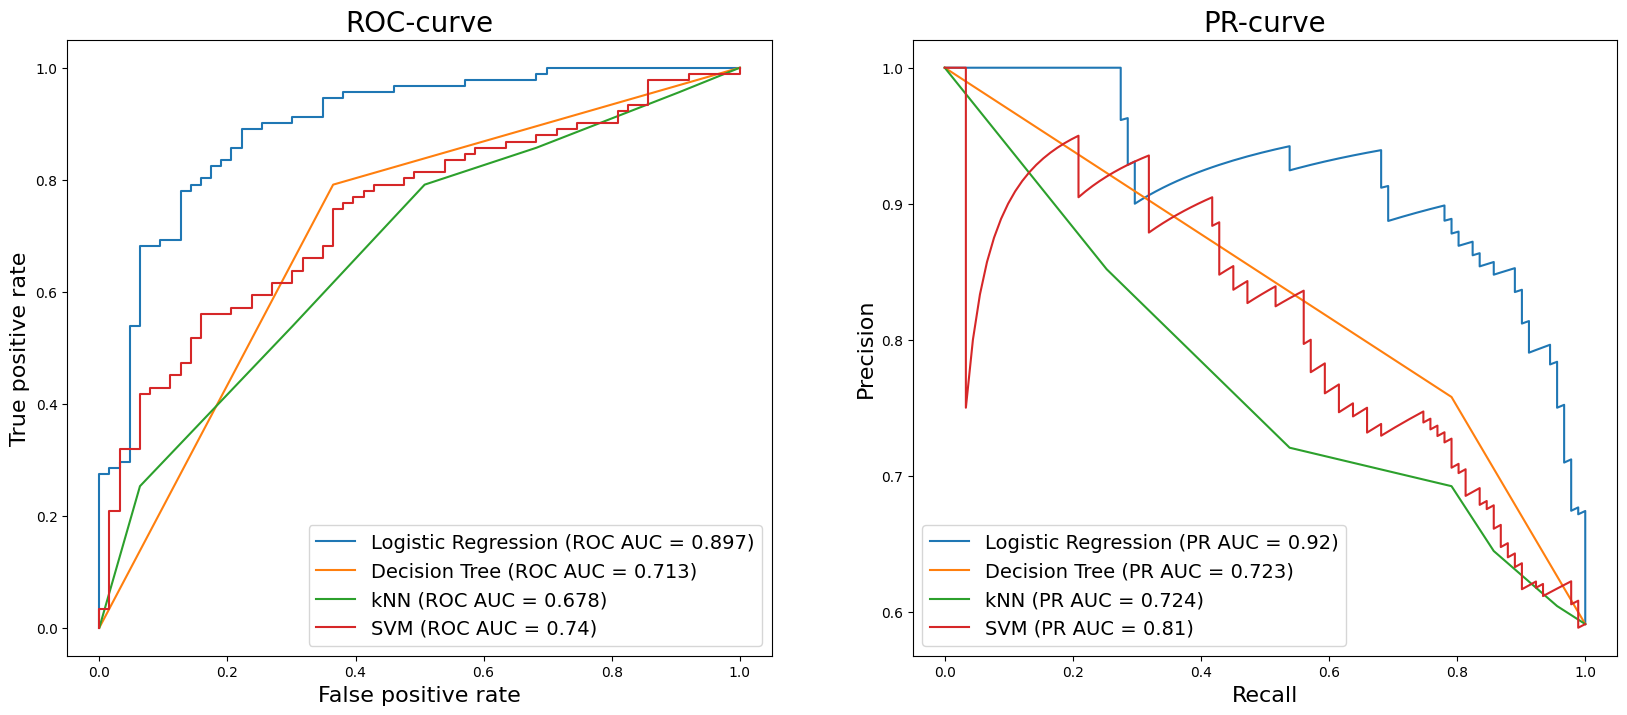

In [645]:
plot_roc_pr_curves(
    y_test,
    {
        "Logistic Regression": proba_logreg,
        "Decision Tree": proba_dt,
        "kNN": proba_knn,
        "SVM": proba_svm,
    }
)

Let's aggregate all model metrics

In [646]:
ans_df = pd.DataFrame(
    [all_metrics_logreg, all_metrics_dt, all_metrics_knn, all_metrics_svm],
    index=["Logistic Regression", "Decision Tree", "kNN", "SVM"]
)
ans_df

,Accuracy,Balanced accuracy,Precision,Recall,F1_score,ROC AUC,PR AUC,Specificity
Logistic Regression,0.8377,0.8260,0.8438,0.8901,0.8663,0.8973,0.9201,0.7619
Decision Tree,0.7273,0.7131,0.7579,0.7912,0.7742,0.7131,0.7230,0.6349
kNN,0.6688,0.6416,0.6923,0.7912,0.7385,0.6779,0.7244,0.4921
SVM,0.6558,0.6087,0.6583,0.8681,0.7488,0.7401,0.8103,0.3492


For each metric, we will list the models in descending order of their quality

In [647]:
for metric in ans_df.columns:
    sorted_ans_df = ans_df.sort_values(by=metric, ascending=False)
    print(
        "{}:{}{}".format(
            metric,
            " " * (20 - len(metric)),
            sorted_ans_df.index.tolist()
        )
    )

Accuracy:            ['Logistic Regression', 'Decision Tree', 'kNN', 'SVM']
Balanced accuracy:   ['Logistic Regression', 'Decision Tree', 'kNN', 'SVM']
Precision:           ['Logistic Regression', 'Decision Tree', 'kNN', 'SVM']
Recall:              ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']
F1_score:            ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
ROC AUC:             ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']
PR AUC:              ['Logistic Regression', 'SVM', 'kNN', 'Decision Tree']
Specificity:         ['Logistic Regression', 'Decision Tree', 'kNN', 'SVM']


Result: According to most metrics, error matrix **_Logistic Regression_** proved to be the best algorithm.


### IV. Order and visualise the regression coefficients for each trait

In [648]:
# Define the plot_imp function, which takes two arguments: appendix and importance.
# The arguments of the function are lists or arrays that will be used to plot the graph:
def plot_imp(appendix, importance):
# Create an order list that contains the indices of the elements of the importance array ordered in descending order.
# The argsort function from the NumPy library is used to sort arrays:
    order = np.argsort(importance)
# Assign the variables arteria and importance to a new list that contains the elements of the original list arteria,importance
# ordered according to the order defined in order:
    appendix = appendix[order]
    importance = importance[order]

    for idx, val in enumerate(importance):
        print(f'{appendix[idx]:40} {val:.4f}')
    plt.figure(figsize=(4, np.ceil(len(appendix) / 4)))
    plt.title('Visualisation the regression coefficients for each trait')
    plt.barh(appendix, importance) # draws a histogram
    plt.show() # displays the graph on the screen

Ipsilateral_Rebound_Tenderness           -1.0248
Perfusion_hypoperfused                   -0.8825
Peritonitis_local                        -0.7000
Appendix_Wall_Layers_intact              -0.5917
Dysuria                                  -0.5883
Neutrophil_Percentage                    -0.4977
Appendicular_Abscess                     -0.4724
CRP                                      -0.4426
Alvarado_score_calculated                -0.2839
Sex                                      -0.2776
Stool_no_information                     -0.2451
Thrombocyte_Count                        -0.2216
Ketones_in_Urine                         -0.1669
Diagnosis                                -0.1554
Loss_of_Appetite                         -0.1523
Coughing_Pain                            -0.0494
Peritonitis_no                           -0.0455
BMI                                      -0.0363
Appendix_on_US                           -0.0353
Neutrophilia                             -0.0222
RDW                 

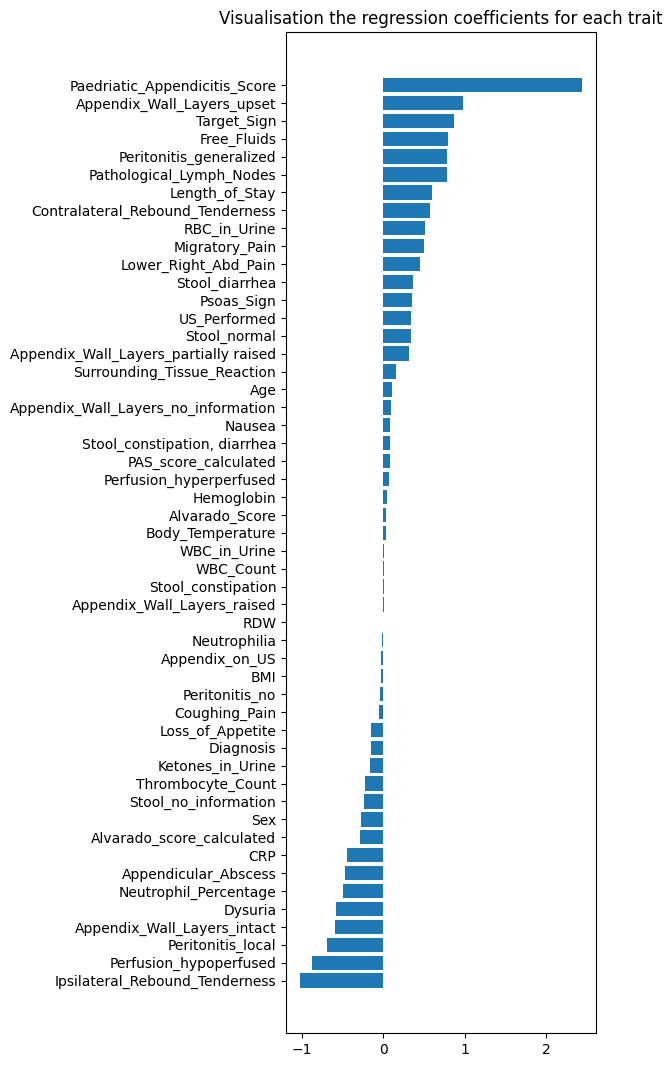

In [649]:
appendix = data.columns
plot_imp(appendix, importance_logreg)


Let's derive the absolute contribution of features to the prediction

RDW                                      0.0007
Appendix_Wall_Layers_raised              0.0032
Stool_constipation                       0.0038
WBC_Count                                0.0060
WBC_in_Urine                             0.0120
Neutrophilia                             0.0222
Body_Temperature                         0.0351
Appendix_on_US                           0.0353
Alvarado_Score                           0.0357
BMI                                      0.0363
Peritonitis_no                           0.0455
Hemoglobin                               0.0465
Coughing_Pain                            0.0494
Perfusion_hyperperfused                  0.0633
PAS_score_calculated                     0.0783
Stool_constipation, diarrhea             0.0791
Nausea                                   0.0791
Appendix_Wall_Layers_no_information      0.0957
Age                                      0.1076
Loss_of_Appetite                         0.1523
Diagnosis                               

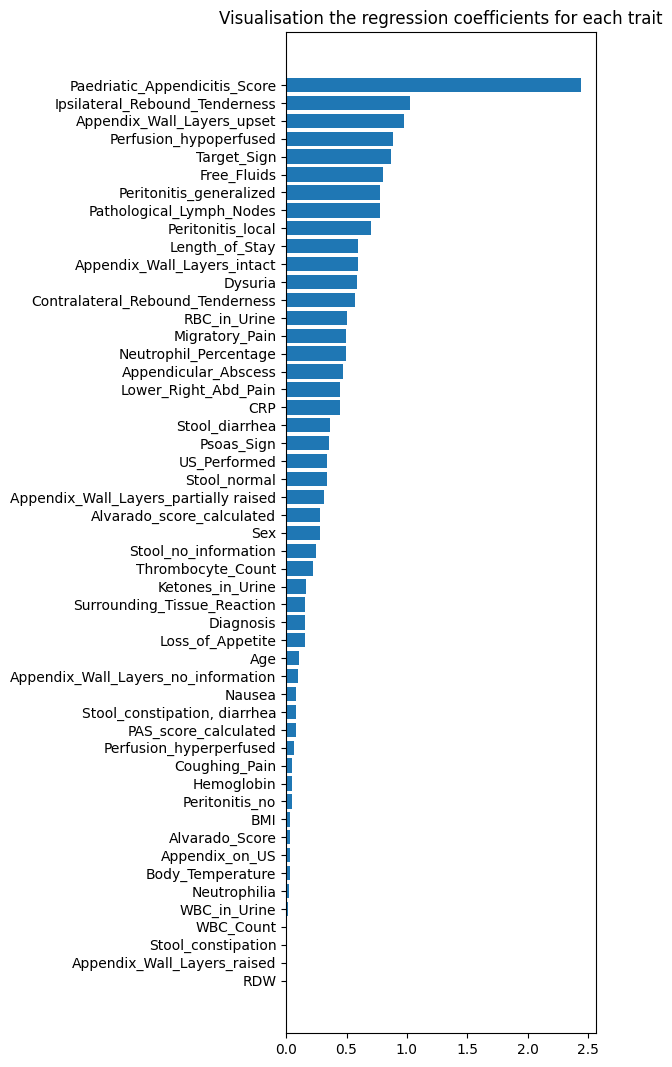

In [650]:
plot_imp(appendix, np.abs(importance_logreg))


### V. Optimise the performance of model by fitting hyperparameters. 

Let's use Grid Search. He will find the most effective results.

In [651]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 300, 500]
}

grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # or 'accuracy', 'f1', etc.
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best ROC AUC:", grid.best_score_)


Best parameters: {'C': 1, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}
Best ROC AUC: 0.8484599039006776


C:\Users\ТЕСТ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [652]:
pred_logreg, proba_logreg, importance_logreg, all_metrics_logreg = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    LogisticRegression(C = 1, class_weight = 'balanced', l1_ratio = 0.1, max_iter = 500, penalty='elasticnet', solver='saga', random_state=42)
)

C:\Users\ТЕСТ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.1, max_iter=500,
                   penalty='elasticnet', random_state=42, solver='saga')

Accuracy = 0.7403
Balanced_accuracy=0.746
Precision = 0.8228
Recall = 0.7143
F1_score = 0.7647
ROC AUC = 0.8275
PR AUC = 0.87
Specificity = 0.7778


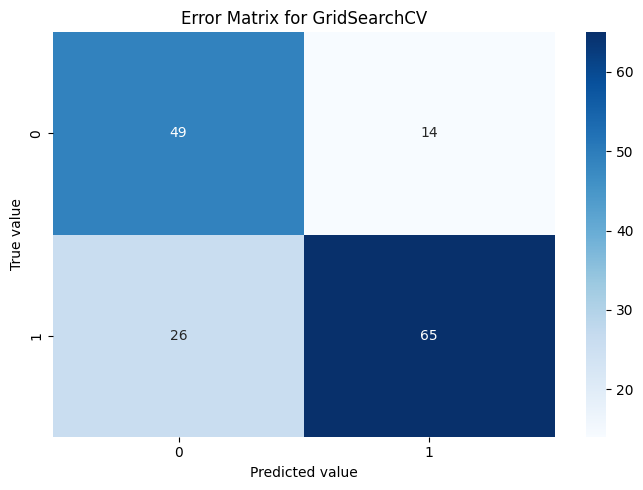

In [653]:
# Construct the error matrix for the model
plot_confusion_matrix(y_test, pred_logreg, title = 'Error Matrix for GridSearchCV')


So far, the results have been worse than they were originally. So far, the results have been worse than they were originally. Let's try other ways of selection (except for manual substitution)

- Random Search

In [654]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the distribution of hyperparameters
param_dist = {
    'C': uniform(loc=0.01, scale=10),              # Continuous distribution from 0.01 to 10
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],                       # Supports both 'l1' and 'l2'
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200, 300, 400, 500]
}

# Set up the randomized search
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_dist,
    n_iter=30,                        # Try 30 random combinations
    scoring='roc_auc',               # Or 'accuracy', 'f1', etc.
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit to training data
random_search.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best ROC AUC:", random_search.best_score_)

Best parameters: {'C': np.float64(0.32313292455558584), 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC: 0.9186640403497777


In [656]:
pred_logreg, proba_logreg, importance_logreg, all_metrics_logreg = model_train_test(
    X_train, y_train.values,
    X_test, y_test.values,
    LogisticRegression(C = 1, class_weight = 'balanced', l1_ratio = 0.1, max_iter = 200, penalty='l2', solver='liblinear', random_state=42)
)

LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.1, max_iter=200,
                   random_state=42, solver='liblinear')

Accuracy = 0.8182
Balanced_accuracy=0.8168
Precision = 0.8621
Recall = 0.8242
F1_score = 0.8427
ROC AUC = 0.899
PR AUC = 0.9225
Specificity = 0.8095


C:\Users\ТЕСТ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


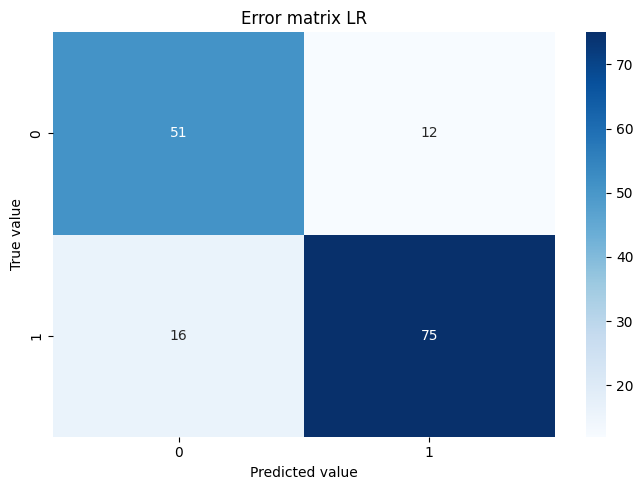

In [657]:
plot_confusion_matrix(y_test, pred_logreg, title='Error matrix LR')

POC AUC, Precision, Specificity increased by 4%. Other parameters deteriorated compared to the initial values.
But Error Matrix was better on the first try.


Finally, we look again at the contribution of the indicators to the predictive power of the model:

Ipsilateral_Rebound_Tenderness           -0.9934
Perfusion_hypoperfused                   -0.9624
Dysuria                                  -0.6399
Peritonitis_local                        -0.6386
Appendix_Wall_Layers_intact              -0.6302
Appendicular_Abscess                     -0.5863
Neutrophil_Percentage                    -0.5257
CRP                                      -0.5179
Sex                                      -0.2992
Alvarado_score_calculated                -0.2800
Stool_no_information                     -0.2351
Thrombocyte_Count                        -0.2124
Ketones_in_Urine                         -0.1692
Loss_of_Appetite                         -0.1624
Diagnosis                                -0.1361
Coughing_Pain                            -0.0573
BMI                                      -0.0340
Appendix_on_US                           -0.0252
PAS_score_calculated                     -0.0234
Neutrophilia                             -0.0206
Peritonitis_no      

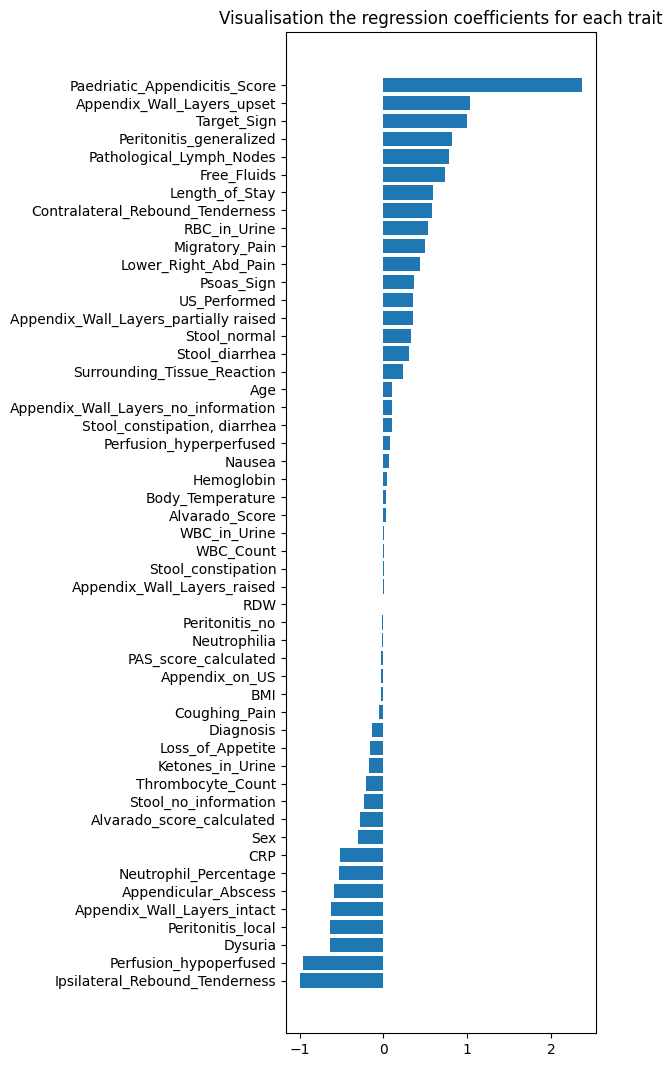

In [658]:
appendix = data.columns
plot_imp(appendix, importance_logreg)

IV. Conclusion

- We trained the most accurate model possible. We achieved a model accuracy of 82% in predicting paediatric appendicitis. For medical research, this is a high result.
- The clearest marker of the disease is the PAS score of the child. It is more effective than the Alvarado Score. The latter may not be used to assess a child's disease.
- PAS, Ipsilateral_Rebound_Tenderness, Appendix_Wall_Layers_upset, Perfusion_hypoperfused, Target_Sign and Free_Fluid (column explanations are available in the database) should also be given serious consideration.